# Sklearn model building example

Sklearn comes with many more functionalities than just training the parameters of a model. The main benefit of sklearn is actually in organizing the workflow *around* training a model. Think of functionalities such as splitting the data or cross-validation, but also preprocessing of data and the use of pipelines. 

Training the parameters of a machine learning model is not difficult. But ensuring that the process is done in such a way that your results give you the best possible representation of how well your model will perform for the next instance in your process can go wrong in many, many different ways.

In this notebook we go through a pipeline example, where some fundamental functionalities of sklearn are unpacked, small-step by small-step, such that you will understand far better what is happening under the hood when training models using sklearn.

Needless to say, there is much, much more to sklearn than shown below. Please do visit https://scikit-learn.org/stable/ to further investigate all the possibilities of this important package.

As always, we start with importing the relevant modules.

In [2]:
#import relevant modules
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

#from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

## Loading the Data

We work with a toy dataset, containing sonar data which can be used to classify objects as being either a Mine or a Rock. More information on the dataset can be found at: https://datahub.io/machine-learning/sonar.

In [3]:
df = pd.read_csv('https://datahub.io/machine-learning/sonar/r/sonar.csv')
df.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,Rock
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,Rock
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,Rock
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,Rock
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,Rock


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   attribute_1   208 non-null    float64
 1   attribute_2   208 non-null    float64
 2   attribute_3   208 non-null    float64
 3   attribute_4   208 non-null    float64
 4   attribute_5   208 non-null    float64
 5   attribute_6   208 non-null    float64
 6   attribute_7   208 non-null    float64
 7   attribute_8   208 non-null    float64
 8   attribute_9   208 non-null    float64
 9   attribute_10  208 non-null    float64
 10  attribute_11  208 non-null    float64
 11  attribute_12  208 non-null    float64
 12  attribute_13  208 non-null    float64
 13  attribute_14  208 non-null    float64
 14  attribute_15  208 non-null    float64
 15  attribute_16  208 non-null    float64
 16  attribute_17  208 non-null    float64
 17  attribute_18  208 non-null    float64
 18  attribute_19  208 non-null    

As we have no categorical features in our data (only the outcome variable Class is categorical), we add two categorical features to our data, such that we can demonstrate the functionalities relating to this data type.

### Question 1
- add a 'batch' feature to the dataframe, containing the levels 'first' (60 rows), 'second' (60 rows), 'third' (remaining rows).
- add a 'location' feature to the dataframe, containing the levels 'loc_A' (20 rows), 'loc_B' (30 rows), 'loc_C' (40 rows), 'loc_D' (50 rows), 'loc_E' (remaining rows).

In [5]:
# answer Q1
df['batch'] = ['first']*60+['second']*60 + ['third']* (len(df)-60-60)
df['location'] = ['loc_A']*20+['loc_B']*30 +['loc_C']*40 +['loc_D']*50 + ['loc_E']* (len(df)-20-30-40-50)
df.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class,batch,location
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,Rock,first,loc_A
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,Rock,first,loc_A
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,Rock,first,loc_A
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,Rock,first,loc_A
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,Rock,first,loc_A


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 63 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   attribute_1   208 non-null    float64
 1   attribute_2   208 non-null    float64
 2   attribute_3   208 non-null    float64
 3   attribute_4   208 non-null    float64
 4   attribute_5   208 non-null    float64
 5   attribute_6   208 non-null    float64
 6   attribute_7   208 non-null    float64
 7   attribute_8   208 non-null    float64
 8   attribute_9   208 non-null    float64
 9   attribute_10  208 non-null    float64
 10  attribute_11  208 non-null    float64
 11  attribute_12  208 non-null    float64
 12  attribute_13  208 non-null    float64
 13  attribute_14  208 non-null    float64
 14  attribute_15  208 non-null    float64
 15  attribute_16  208 non-null    float64
 16  attribute_17  208 non-null    float64
 17  attribute_18  208 non-null    float64
 18  attribute_19  208 non-null    

As this dataset does not have any missings, we will introduce some random missings such that we are forced to make use of more sklearn preprocessing functionalities.

### Question 2
Replace a random 10% of the dataframe by missing values.

In [7]:
# answer Q2
np.random.seed(42)
mask = np.random.choice([True, False], p=[0.1, 0.9], size=df.shape)
mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [8]:
# answer Q2 continued
# replace original df:
df = df.mask(mask)
df.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60,Class,batch,location
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,NaN,0.1601,0.3109,0.2111,...,0.0159,0.0072,0.0167,NaN,0.0084,NaN,0.0032,Rock,first,loc_A
1,0.0453,0.0523,0.0843,0.0689,0.1183,NaN,0.2156,0.3481,0.3337,NaN,...,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,Rock,first,loc_A
2,0.0262,0.0582,NaN,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,Rock,first,loc_A
3,0.0100,NaN,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0150,0.0085,NaN,0.0050,0.0044,0.0040,0.0117,Rock,first,loc_A
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,NaN,0.3564,0.4459,...,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,NaN,NaN,first,loc_A


The next step is to split the data into a random train (70%) and test (30%) set, such that we can perform model selection in the next section on the train set, and finally perform model assessment on the test set.

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df['Class']):
  strat_train_set = df.loc[train_index]
  strat_test_set = df.loc[test_index]

ValueError: ignored

This is not working due to missings in the outcome variable, which causes StratifiedShuffleSplit to fail, because we ask it to perform a split where the distribution of our outcome variable Class is comparable across both the train and test set. And when the outcome variable Class contains missings, that procedure fails.

This puts us in a Catch 22: we cannot impute the outcome variable using only the training data on outcomes, as our training data has to be defined based on our outcome variable. Please note this will not be a problem when the split between train and test data is not done randomly, but rather based on time, or location. In our case, however, it is a problem, and this is typically the point where you check whether the missing outcome data can be retrieved through other means, where you decide to drop missings, or decide to impute the outcome data. 

For now we will impute the missing *outcome* values with the most occurring value, and use the preprocessing functionality of sklearn for this task. We will use this functionality again after splitting the data to impute missings in the *predictors*, as this will ensure that we do the exact same preprocessing on the predictors in the test set.

### Question 3
Missings in the outcome variable are more problematic than missings in the predictor variables. 
- Why is this the case? 
- What are the potential downsides of imputing the outcome variable?
- What are the potential downsides of removing instances with missing outcome data?

For now we take a simple approach and impute the missing outcome values with the most frequent class.

In [10]:
from sklearn.impute import SimpleImputer
imp_outcome = SimpleImputer(strategy = 'most_frequent')
imp_outcome.fit(df['Class'].to_frame())

SimpleImputer(strategy='most_frequent')

The code above created an 'impute object' that has been fitted on df['Class'] to determine what the imputation value should be. The outcome Class has not been 'transformed' yet, and so it will still contain missing values.

In [11]:
sum(df['Class'].isnull())

15

The value that will be imputed when using the impute object to transform a variable, is saved in *.statistics_*, as shown below (and equals 'Mine', which is indeed the most_frequent value in df['Class']).

In [12]:
imp_outcome.statistics_

array(['Mine'], dtype=object)

The current distribution of df['Class'] is:

In [13]:
df['Class'].value_counts()

Mine    101
Rock     92
Name: Class, dtype: int64

We now impute the missing values of df['Class'] by applying 'transform' on df['Class'].

In [14]:
df['Class'] = imp_outcome.transform(df['Class'].to_frame())
sum(df['Class'].isnull())

0

In [15]:
df['Class'].value_counts()

Mine    116
Rock     92
Name: Class, dtype: int64

We could have done both the fitting and transforming in one go using the command imp_outcome.fit_transform().

We are now ready to proceed with splitting the data into a train and test set

In [16]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df, df['Class']):
  strat_train_set = df.loc[train_index]
  strat_test_set = df.loc[test_index]

In [17]:
print('share of observations in the train set:', str(round(len(strat_train_set)/len(df), 3)))
print('share of observations in the test set:', str(round(len(strat_test_set)/len(df), 3)))
print('share of mines in the train set:', str(round(len(strat_train_set.loc[strat_train_set['Class'] == 'Mine'])/len(strat_train_set), 3)))
print('share of mines in the test set:', str(round(len(strat_test_set.loc[strat_test_set['Class'] == 'Mine'])/len(strat_test_set), 3)))


share of observations in the train set: 0.697
share of observations in the test set: 0.303
share of mines in the train set: 0.559
share of mines in the test set: 0.556


We now split the features from the outcome data for both the train and the test set, to align with the input needed when using sklearn to train models.

In [18]:
# split features and outcome data
X_train = strat_train_set.loc[:,strat_train_set.columns != 'Class']
y_train = strat_train_set['Class']
X_test = strat_test_set.loc[:,strat_test_set.columns != 'Class']
y_test = strat_test_set['Class']

## Setting up the pipeline

Machine learning is about trial and error, with typically many iterations between different ways to prepare the data (data preparation) and assessing how that translates into performance (model building).

Going through different iterations should require the least possible effort, which is done by setting up a pipeline, using sklearn's pipeline functionality. A pipeline explicitly operationalizes all the different steps to get from raw data into data prepared and ready to serve as modeling input.


As such, the pipeline serves multiple purposes: 
- it encompasses every preprocessing step, coded within an overarching Python object, such that new data is really easy to preprocess consistently (the raw test data or tomorrow's raw process data). This approach prevents 'manual' adjustments to the data, that would get lost or would need to be repeated 'manually' when preparing new data; 
- it makes it really easy to tweak the preprocessing steps, trying out different ways to prepare the data, requiring minimal adjustment to your code (less time-consuming and less error-prone);
- it helps in preventing mistakes that contribute to data leakage.

Typical preprocessing steps captured in a pipeline include:
- selecting the variables
- imputing missing values
- scaling numeric variables
- creating dummy variables for categorical variables

On top of that, there is full flexibility in defining your own preprocessing steps within a pipeline.

Below, we will set up the typical pipeline step-by-step. 

The first thing to realize is that numeric and categorical features require different preprocessing steps, effectively meaning that our overarching pipeline should contain two parallel pipelines: one for preparing numeric features and one for preparing categorical features

In [19]:
# dividing the features into numeric and non-numeric
num_features = X_train.select_dtypes(include=['float']).columns
cat_features = X_train.select_dtypes(exclude=['float']).columns
print(num_features)
print(cat_features)

Index(['attribute_1', 'attribute_2', 'attribute_3', 'attribute_4',
       'attribute_5', 'attribute_6', 'attribute_7', 'attribute_8',
       'attribute_9', 'attribute_10', 'attribute_11', 'attribute_12',
       'attribute_13', 'attribute_14', 'attribute_15', 'attribute_16',
       'attribute_17', 'attribute_18', 'attribute_19', 'attribute_20',
       'attribute_21', 'attribute_22', 'attribute_23', 'attribute_24',
       'attribute_25', 'attribute_26', 'attribute_27', 'attribute_28',
       'attribute_29', 'attribute_30', 'attribute_31', 'attribute_32',
       'attribute_33', 'attribute_34', 'attribute_35', 'attribute_36',
       'attribute_37', 'attribute_38', 'attribute_39', 'attribute_40',
       'attribute_41', 'attribute_42', 'attribute_43', 'attribute_44',
       'attribute_45', 'attribute_46', 'attribute_47', 'attribute_48',
       'attribute_49', 'attribute_50', 'attribute_51', 'attribute_52',
       'attribute_53', 'attribute_54', 'attribute_55', 'attribute_56',
       'attribu

We will now define a 'numeric pipeline' and a 'categorical pipeline', which is then combined into a 'full pipeline'.

We start off with the 'numeric pipeline', containing the steps of imputing missing values, and standardizing the feature values (which is required for some machine learning algorithms, and speeds up estimation for others). As the imputation strategy within the numeric pipeline only applies to numeric features, imputation can be straightforwardly applied using median imputation (or comparable methods).

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

### Question 4
- make a copy of the dataframe (df_tmp = df.copy())
- fit the SimpleImputer based on median values on the numeric features
- fit a StandardScaler on the numeric features
- check the fitted statistics of both objects

In [21]:
# answer Q4
df_tmp = df.copy()
imp_nums = SimpleImputer(strategy = 'median')
imp_nums.fit(df_tmp[num_features])

sc_nums = StandardScaler()
sc_nums.fit(df_tmp[num_features])

StandardScaler()

In [22]:
# answer Q4 continued
imp_nums.statistics_

array([0.02285, 0.0308 , 0.0344 , 0.0445 , 0.0597 , 0.08885, 0.10695,
       0.1119 , 0.15375, 0.185  , 0.23275, 0.2555 , 0.2656 , 0.2821 ,
       0.2885 , 0.2956 , 0.31   , 0.36535, 0.4416 , 0.5448 , 0.6177 ,
       0.6689 , 0.6987 , 0.6954 , 0.7221 , 0.7511 , 0.7552 , 0.7319 ,
       0.679  , 0.6152 , 0.492  , 0.4289 , 0.39375, 0.3776 , 0.3032 ,
       0.3043 , 0.2934 , 0.315  , 0.2736 , 0.2811 , 0.258  , 0.2546 ,
       0.22255, 0.17715, 0.1459 , 0.12435, 0.09905, 0.0787 , 0.0447 ,
       0.01765, 0.0139 , 0.01165, 0.00935, 0.0093 , 0.0075 , 0.0068 ,
       0.00575, 0.00595, 0.0067 , 0.0051 ])

In [23]:
# answer Q4 continued
# the statistics of the standardscaler are the mean and std
print(sc_nums.mean_)
print(sc_nums.scale_)

[0.02981848 0.03900267 0.04495916 0.05550309 0.07267322 0.10047083
 0.12278895 0.13432703 0.17985426 0.21186383 0.24066505 0.25461421
 0.27646117 0.29873602 0.32655319 0.36989577 0.42186919 0.44871359
 0.50622383 0.56435167 0.60795105 0.62547423 0.6477306  0.67586021
 0.67348883 0.6966328  0.70566402 0.69236978 0.63819686 0.58505714
 0.50554545 0.43943825 0.41847819 0.40936021 0.38176292 0.38007906
 0.35844375 0.343875   0.32421148 0.3162884  0.28658698 0.28599676
 0.24733526 0.21202344 0.18910335 0.16432527 0.12248    0.09246979
 0.05258617 0.01997581 0.01637722 0.01364158 0.01048021 0.01082434
 0.00924513 0.00823194 0.00786868 0.00814946 0.00824064 0.00595955]
[0.02388212 0.03375822 0.0390138  0.04744442 0.05391535 0.05171558
 0.06274879 0.08428762 0.11824461 0.13874544 0.13344632 0.14184468
 0.13699275 0.16576797 0.20392106 0.22907284 0.26981026 0.25711721
 0.25495359 0.26336943 0.25676953 0.25897107 0.25142398 0.24095289
 0.24435109 0.23467517 0.24413179 0.23925971 0.24156473 0.214

### Unpacking the pipeline

Let's now unpack this part of our pipeline:
num_pipeline is now a Pipeline object, which, as you would expect, simply passes on the input it receives through each of the elements of the pipeline. Each element of the Pipeline uses the output of the previous step as its input.

Each element is given a user-defined name, and is accompanied by a specific preprocessing step, which is often a function imported from the sklearn.preprocessing module, but could also be a user-defined function. Each element in the Pipeline can be accessed individually, as shown below:

In [24]:
type(num_pipeline)

sklearn.pipeline.Pipeline

In [25]:
num_pipeline

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('std_scaler', StandardScaler())])

Each functionality can be accessed individually as follows:




In [26]:
num_pipeline['imputer']

SimpleImputer(strategy='median')

Just as we saw above, this preprocessing functionality can be used to transform data, but it needs to be fitted on data first (or it can be done simultaneously). Once we fit the num_pipeline to our numerical training data, it will contain medians to be imputed and scaling factors to be applied, making it possible to use the pipeline for transforming data according to these preprocessing steps.

In [27]:
# transforming will give an error, until the pipeline is being fitted (as stated in the NotFittedError below)
num_pipeline.transform(X_train[num_features])

NotFittedError: ignored

In [28]:
num_pipeline.fit(X_train[num_features])

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('std_scaler', StandardScaler())])

Now the imputer and standard scaler do contain fitted statistics that can be applied to transform data according to these preprocessing steps. These statistics can be accessed by going into the pipeline object, to the specific pipeline elements.

In [29]:
# the statistics_ for the imputer step contains the medians to be used for imputation
num_pipeline['imputer'].statistics_

array([0.0228 , 0.02925, 0.038  , 0.0454 , 0.06105, 0.0932 , 0.1122 ,
       0.113  , 0.1553 , 0.18705, 0.2373 , 0.2551 , 0.27065, 0.2976 ,
       0.3039 , 0.3047 , 0.3068 , 0.3771 , 0.4433 , 0.5425 , 0.6496 ,
       0.6628 , 0.7052 , 0.69325, 0.72775, 0.7545 , 0.7654 , 0.7321 ,
       0.634  , 0.6005 , 0.492  , 0.4241 , 0.3897 , 0.3682 , 0.3369 ,
       0.31035, 0.2821 , 0.315  , 0.28905, 0.2883 , 0.2609 , 0.2633 ,
       0.2207 , 0.1755 , 0.14955, 0.12785, 0.0947 , 0.08055, 0.049  ,
       0.0179 , 0.014  , 0.0115 , 0.00865, 0.0093 , 0.0075 , 0.0065 ,
       0.0057 , 0.0058 , 0.0069 , 0.0048 ])

In [30]:
# the statistics of the standardscaler are the mean and std
means = num_pipeline['std_scaler'].mean_
scale = num_pipeline['std_scaler'].scale_
pd.DataFrame({'Means':means, 'Scale':scale}, index=X_train[num_features].columns)

,Means,Scale
attribute_1,0.030316,0.024040
attribute_2,0.038669,0.035053
attribute_3,0.047230,0.041599
attribute_4,0.057621,0.050468
attribute_5,0.074851,0.055196
attribute_6,0.101849,0.048008
attribute_7,0.126627,0.063411
attribute_8,0.136208,0.085086
attribute_9,0.183074,0.117458
attribute_10,0.215243,0.135830


## Question 5
Compare the imputer and scaler statistics found here with the statistics found under question 4. Explain any differences.

Answer Q5: 
- first of all these preprocessing steps were applied to different datasets.
- more subtly, even if we do use the same dataset, the mean and scale statistics would still be different, as the pipeline takes as input the data that results from having done the previous preprocessing steps in that same pipeline (i.e. medians have been added, altering the means and scales).

Now that the imputer and standard scaler have been fitted, we can use it to transform the numerical train data, and check whether it indeed results in fully imputed, fully standarized data:

In [31]:
X_num_prep = num_pipeline.transform(X_train[num_features])
X_num_prep

array([[ 0.92694488,  0.50297168,  1.79499411, ...,  0.34962688,
         4.36066979,  3.60663451],
       [-0.13792866, -0.63815596, -0.31562267, ...,  0.21471763,
         0.33508158,  0.82479305],
       [-0.18784461,  0.1321052 ,  0.17957899, ..., -0.24996978,
        -0.55085868, -0.21537375],
       ...,
       [-0.30847482, -0.05047522, -1.03919403, ..., -0.75962693,
         0.31953877, -0.2637536 ],
       [-0.74939902, -1.04040346, -0.66418695, ..., -0.32491936,
        -0.56640149,  0.29261469],
       [-0.88666787, -0.92629069, -0.2218709 , ..., -0.39986894,
         1.64067776, -0.2637536 ]])

You see that the pipeline has the typically undesired feature (though it does speed up computing time) of removing the column names. It is good practice to keep track of the column names, which becomes even more important when we apply preprocessing steps that will change the number of features that we have, as we will encounter when preprocessing the categorical features.

In [32]:
X_num_prep = pd.DataFrame(X_num_prep, columns=X_train[num_features].columns)
X_num_prep.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_51,attribute_52,attribute_53,attribute_54,attribute_55,attribute_56,attribute_57,attribute_58,attribute_59,attribute_60
0,0.926945,0.502972,1.794994,1.247895,-0.910411,0.007312,-0.227513,-1.084874,0.391854,-0.383149,...,1.887135,2.171228,0.802669,3.127028,4.007493,1.603111,0.983535,0.349627,4.360670,3.606635
1,-0.137929,-0.638156,-0.315623,-0.652323,0.133136,0.494733,0.089465,0.260823,0.158578,-0.022404,...,0.331137,-0.196059,1.686764,-0.344468,-0.733223,0.209051,1.088333,0.214718,0.335082,0.824793
2,-0.187845,0.132105,0.179579,0.207629,-0.250042,0.482235,0.046886,0.431239,0.820094,0.590127,...,-0.315070,-0.449697,-0.595808,-1.260943,-0.277659,-0.249970,-0.780564,-0.249970,-0.550859,-0.215374
3,-0.778517,-0.592511,-0.056002,1.029934,2.109716,-0.196821,-0.796811,-0.317415,-0.914150,-0.844020,...,-1.080315,0.311217,-0.001053,-0.358354,2.498437,3.354188,0.372213,-0.384879,-0.224460,0.800603
4,-0.587172,-0.381402,-0.505530,-0.376901,-0.187537,-1.138334,-0.331595,0.030468,-0.236458,-0.602542,...,-0.179026,-0.661062,-0.274319,1.696771,1.473417,-0.096963,-0.326440,0.304657,-0.550859,-0.965261


## Question 6
- check whether all missings have been imputed.
- check whether means and standard deviations are 0 and 1 for each feature.

In [33]:
# Answer Q6
# every missing has been imputed
sum(X_num_prep.isnull().sum())

0

In [34]:
# Answer Q6 - continued
# every mean is 0; every standard deviation is 1
mean = X_num_prep.mean(axis=0).round(3)
std = X_num_prep.std(axis=0).round(3)
pd.DataFrame({'Prepped_Means':mean, 'Prepped_Scale':std}, index=X_train[num_features].columns)

,Prepped_Means,Prepped_Scale
attribute_1,0.0,1.003
attribute_2,0.0,1.003
attribute_3,0.0,1.003
attribute_4,0.0,1.003
attribute_5,0.0,1.003
attribute_6,-0.0,1.003
attribute_7,-0.0,1.003
attribute_8,-0.0,1.003
attribute_9,-0.0,1.003
attribute_10,0.0,1.003


### Categorical preprocessing

We took very small steps when walking through the numeric preprocessing pipeline. Now that we have seen the general principles, we will go through the categorical preprocessing pipeline more quickly.

Categorical data are typically preprocessed by imputing (in our example using the 'most_frequent' value), and by 'OneHotEncoding', defining dummy variables out of categorical features.

In [35]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ('cat_imputer', SimpleImputer(strategy = 'most_frequent')),
        ('cat_encoder', OneHotEncoder(sparse=False))])

In [36]:
cat_pipeline.fit(X_train[cat_features])

Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='most_frequent')),
                ('cat_encoder', OneHotEncoder(sparse=False))])

In [37]:
cat_pipeline['cat_imputer'].statistics_

array(['third', 'loc_E'], dtype=object)

In [38]:
X_cat_prep = cat_pipeline.transform(X_train[cat_features])

### Question 7
- Compare the dimensions of the unpreprocessed and the preprocessed categorical data and explain the difference.
- Apply .get_feature_names_out(cat_features) to the categorical encoder component of the pipeline to extract dummy names.
- Create a pandas dataframe containing the prepared categorical features along with the appropriate column names.

In [39]:
# Answer Q7
print('dimension of the original categorical data: ' + str(X_train[cat_features].shape))
print('dimension of the preprocessed categorical data: ' + str(X_cat_prep.shape))

dimension of the original categorical data: (145, 2)
dimension of the preprocessed categorical data: (145, 8)


Answer Q7 - continued:

Our prepared data now contains 8 columns, while we started with 2 categorical features. This is due to the OneHotEncoder transforming the two categorical features (containing 3, and 5 levels) into 1 feature for each level.

In [40]:
# Answer Q7 - continued
# Feature names of these 8 variables are easily accessed through:
cat_pipeline['cat_encoder'].get_feature_names_out(cat_features)

array(['batch_first', 'batch_second', 'batch_third', 'location_loc_A',
       'location_loc_B', 'location_loc_C', 'location_loc_D',
       'location_loc_E'], dtype=object)

In [41]:
# Answer Q7 - continued
cat_names = cat_pipeline['cat_encoder'].get_feature_names_out(cat_features)
pd.DataFrame(X_cat_prep, columns = cat_names).head()

,batch_first,batch_second,batch_third,location_loc_A,location_loc_B,location_loc_C,location_loc_D,location_loc_E
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Full Pipeline

Now that we have constructed the numeric and categorical pipeline, we can define the full pipeline, simply as the combination of both pipelines, wrapped in a ColumnTransformer, which allows for different subsets of features to be passed on to each pipeline.

In [42]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_features),
        ("cat", cat_pipeline, cat_features)])

By applying the fit_transform functionality, this could be applied straight away to the raw data and provide the fully prepared data.

In [43]:
X_train_prep = full_pipeline.fit_transform(X_train)
pd.DataFrame(X_train_prep, columns=[num_features.tolist() + cat_names.tolist()]).head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_59,attribute_60,batch_first,batch_second,batch_third,location_loc_A,location_loc_B,location_loc_C,location_loc_D,location_loc_E
0,0.926945,0.502972,1.794994,1.247895,-0.910411,0.007312,-0.227513,-1.084874,0.391854,-0.383149,...,4.360670,3.606635,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.137929,-0.638156,-0.315623,-0.652323,0.133136,0.494733,0.089465,0.260823,0.158578,-0.022404,...,0.335082,0.824793,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.187845,0.132105,0.179579,0.207629,-0.250042,0.482235,0.046886,0.431239,0.820094,0.590127,...,-0.550859,-0.215374,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-0.778517,-0.592511,-0.056002,1.029934,2.109716,-0.196821,-0.796811,-0.317415,-0.914150,-0.844020,...,-0.224460,0.800603,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.587172,-0.381402,-0.505530,-0.376901,-0.187537,-1.138334,-0.331595,0.030468,-0.236458,-0.602542,...,-0.550859,-0.965261,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


And that's it! Now the training data is fully prepared and ready for the phase of model building. Below you find the full code needed to set up the pipeline, without all the detours taken above, resulting in a compact block of code.


In [ ]:
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler
#from sklearn.impute import SimpleImputer

#num_pipeline = Pipeline([
#        ('imputer', SimpleImputer(strategy="median")),
#        ('std_scaler', StandardScaler()),
#    ])
#
#from sklearn.preprocessing import OneHotEncoder
#
#cat_pipeline = Pipeline([
#        ('cat_imputer', SimpleImputer(strategy = 'most_frequent')),
#        ('cat_encoder', OneHotEncoder(sparse=False))])
#
#from sklearn.compose import ColumnTransformer
#
#full_pipeline = ColumnTransformer([
#        ("num", num_pipeline, num_features),
#        ("cat", cat_pipeline, cat_features)])
#
#num_features = X_train.select_dtypes(include=['float']).columns
#cat_features = X_train.select_dtypes(exclude=['float']).columns
#X_train_prep = full_pipeline.fit_transform(X_train)


## Training and evaluating a machine learning model

### Question 8
- Train a LASSO model using the prepared train data and save the outcomes in a 'results' object (as in the previous notebook).
- Assess the results on the training data by showing performance for different hyperparameter values, and by displaying the confusion matrix.



In [44]:
# Answer Q8
from sklearn.linear_model import LogisticRegression

logL1_clf = LogisticRegression(penalty='l1', solver='liblinear')
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
lasso_alphas = np.linspace(0.1, 20, 200)
grid = dict()
grid['C'] = lasso_alphas
gscv = GridSearchCV(logL1_clf, grid, scoring='accuracy', cv = cv, n_jobs=-1)
results = gscv.fit(X_train_prep, y_train)

In [45]:
# Answer Q8 - continued
results.best_estimator_

LogisticRegression(C=0.4, penalty='l1', solver='liblinear')

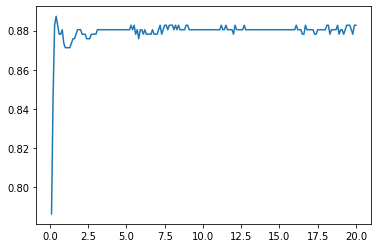

In [46]:
# Answer Q8 - continued
# plot accuracy for different values of C
import matplotlib.pyplot as plt
plt.plot(lasso_alphas, results.cv_results_ ['mean_test_score'])

In [47]:
# Answer Q8 - continued
# get coefficients
results.best_estimator_.coef_

array([[-0.14141528,  0.        ,  0.        ,  0.        , -0.08457593,
         0.        ,  0.16399513,  0.        ,  0.        ,  0.        ,
        -0.45534805, -0.19598733,  0.        ,  0.13732605,  0.16919906,
         0.13201218,  0.        ,  0.        ,  0.        , -0.38319604,
         0.        ,  0.        , -0.03348074, -0.0077538 ,  0.        ,
         0.        ,  0.        , -0.14394787,  0.        ,  0.        ,
         0.        ,  0.        ,  0.14933143,  0.        ,  0.31678248,
         0.        ,  0.        ,  0.        ,  0.        ,  0.03807652,
         0.        ,  0.        ,  0.        , -0.30761782, -0.31161718,
         0.        ,  0.        , -0.11525457, -0.02291123,  0.        ,
        -0.0859967 ,  0.        , -0.01578473,  0.        ,  0.        ,
         0.        ,  0.        , -0.24669139, -0.67671816,  0.        ,
         1.39503898,  0.        ,  0.        ,  0.        ,  0.        ,
         0.73332645, -1.30718648, -2.02138658]])

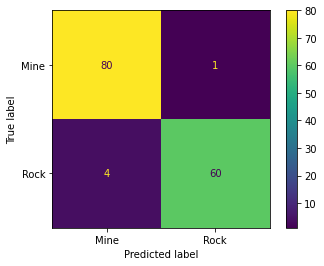

In [48]:
# Answer Q8 - continued
cm = confusion_matrix(y_train, results.best_estimator_.predict(X_train_prep), labels=results.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=results.classes_)
disp.plot()

The accuracy obtained from predicting training data outcomes, using:

In [49]:
accuracy_score(results.predict(X_train_prep), y_train)

0.9655172413793104

is different from the accuracy reported in the 'best_score_':

In [50]:
results.best_score_

0.8873563218390805

### Question 9
- explain the difference, considering that results.best_score_ is the maximum value in results.cv_results_['mean_test_score']
- apply the best LASSO model to the test data using accuracy_score(results.predict(X_test), y_test)
- prepare the test features using the full_pipeline and check the means and standard deviations of the prepared test features
- provide the confusion matrix for the test data

Answer Q9:

The difference is due to best_score_ taking the average of the performance on the folds not used for model building, whereas using the model to predict outcomes for X_train_prep will apply the model to all the instances used for fitting that model, which will generally greatly exaggerate model performance as we are now assessing the model on data on which it was also trained.

In [51]:
# Answer Q9 - continued
accuracy_score(results.predict(X_test), y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


ValueError: ignored

In [52]:
# Answer Q9 - continued
X_test_prep = full_pipeline.transform(X_test)
X_test_prep = pd.DataFrame(X_test_prep, columns=[num_features.tolist() + cat_names.tolist()])
X_test_prep.head()

,attribute_1,attribute_2,attribute_3,attribute_4,attribute_5,attribute_6,attribute_7,attribute_8,attribute_9,attribute_10,...,attribute_59,attribute_60,batch_first,batch_second,batch_third,location_loc_A,location_loc_B,location_loc_C,location_loc_D,location_loc_E
0,-0.312634,-0.504073,-0.457452,0.039206,-0.519081,-0.498855,0.155699,-0.684103,-0.674914,-0.431003,...,-0.550859,-0.844312,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.383349,-0.738005,-1.099291,-0.250087,-0.067964,1.134211,0.396981,-0.183433,-0.140253,-0.594443,...,-0.504230,-1.062021,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.845071,-0.318640,-0.678610,-0.406622,-0.602420,-1.702826,-1.501731,-0.835714,0.055562,0.379570,...,0.117482,-0.021854,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.071374,0.189162,-0.469472,-0.796970,-0.660395,-0.059344,-0.102929,0.553468,0.233499,0.652706,...,-0.504230,-0.263754,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.312634,0.037962,0.718051,0.461256,-0.412190,-0.180157,-1.768245,-0.808683,-0.456963,-0.207562,...,0.863537,1.260212,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [53]:
# Answer Q9 - continued
mean = X_test_prep[num_features].mean(axis=0).round(3)
std = X_test_prep[num_features].std(axis=0).round(3)
pd.DataFrame({'Prepped_Means':mean, 'Prepped_Scale':std}, index=X_test_prep[num_features].columns)

,Prepped_Means,Prepped_Scale
attribute_1,-0.180,0.772
attribute_2,-0.061,0.693
attribute_3,-0.225,0.585
attribute_4,-0.183,0.641
attribute_5,-0.214,0.679
attribute_6,-0.133,1.117
attribute_7,-0.248,0.791
attribute_8,-0.164,0.769
attribute_9,-0.157,0.854
attribute_10,-0.140,0.906


Answer Q9 - continued 

Be careful not to use 'fit_transform' with the pipeline, but only 'transform', as we have to use the fitted information (scaling etc) from the training data. One way to remember this is to see the test data as something that does not come in batches, but in single instances: you want your model to work on new, single observations. A single observation cannot be scaled to mean 0 and standard deviation 1, which is one way to remember why we apply the preprocessing parameters derived in the train set to prepare the test set.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


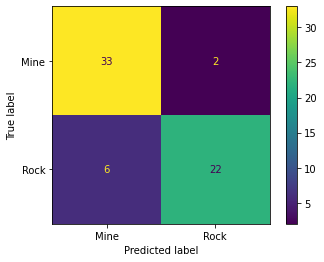

In [54]:
# Answer Q9 - continued
cm = confusion_matrix(y_test, results.predict(X_test_prep), labels=results.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=results.classes_)
disp.plot()

In [55]:
# Answer Q9 - continued
accuracy_score(results.predict(X_test_prep), y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


0.873015873015873

# Conclusion

This notebook took a 'small step by small step' approach to developing a model. Sklearn has extensive functionalities, and the risk in using such a powerful module is that you lose sight of what is happening and start leaning on the preprogrammed features too easily. 

Especially when you start out working with sklearn and its wide array of applications, it really pays off to take this step by step approach to keep track of what is happening as much as possible. 